<a href="https://colab.research.google.com/github/eduion/DeepRL/blob/main/HW4/HW4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW4-1

1. 環境設定

格子世界 (4x4 static):agent 起點為 (0,0)，目標為 (3,3)。

狀態 𝑠 : 將 4x4x4 的多通道棋盤 board.render_np() 平坦化為長度 64 的向量，並加入少量雜訊。

動作𝑎 : 4 種方向（上／下／左／右）。

獎勵 r：每走一步 −1到達終點 +10終止條件為抵達終點。

2. Q-網路結構

三層全連接網路：

輸入：64 維狀態向量

隱藏層：如 128 → 64，ReLU 激活

輸出：4 維 Q value (上下左右)

3. 策略與更新

ε-greedy：以概率 ε 隨機選動作，否則選取最大 Q 值對應的動作。

Temporal-Difference 目標：

Loss: L=(Q(s,a)−y)^2 ，使用 Adam 進行單步更新。

4. 訓練比較
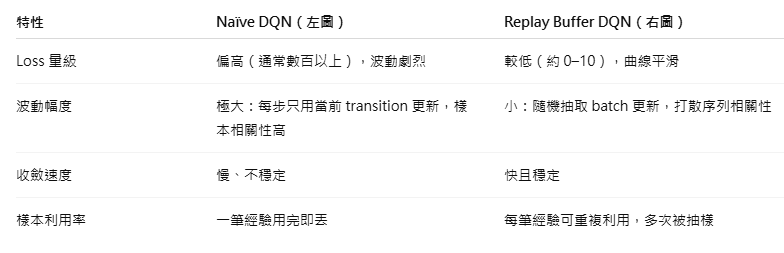

Experience Replay Buffer 是將agent與環境互動獲得的每一筆經驗
(s,a,r,s')存入一個固定大小的記憶池，然後在每次更新時隨機抽取一小批（batch）過去經驗來做梯度下降。
優勢：

打散時間相關性：用隨機抽樣取代連續步驟，減少樣本之間的高度相關性。

重複利用經驗：一筆 transition 能用多次，提升學習效率。

平滑梯度更新：batch 平均掉極端回報，讓訓練更穩定、收斂更快。

In [3]:
# 1. 下載並使用外部 Gridworld.py 和 GridBoard.py
# 請將下列 URL 換成 raw 檔案的連結
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

In [4]:
import random

import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

In [5]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

naive DQN

Text(0, 0.5, 'Loss')

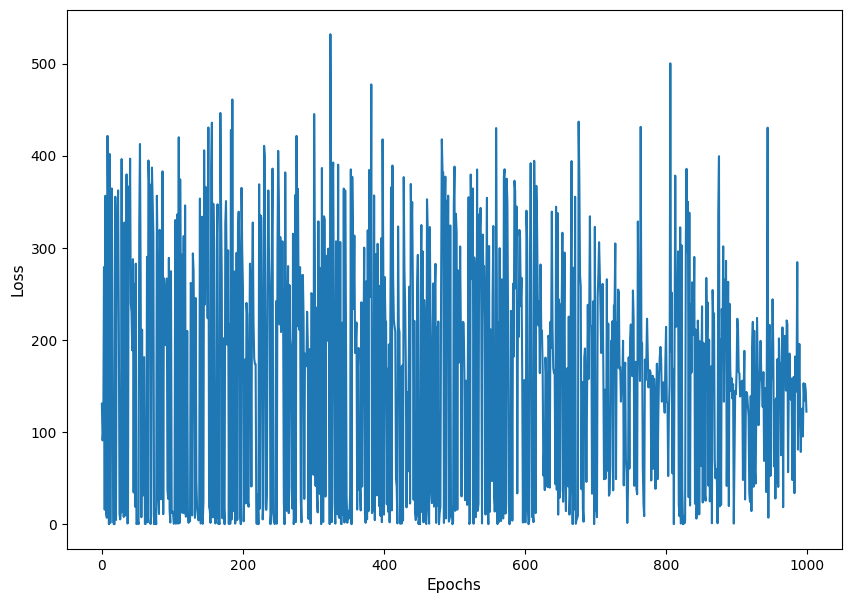

In [7]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

replay buffer DQN

Text(0, 0.5, 'Loss')

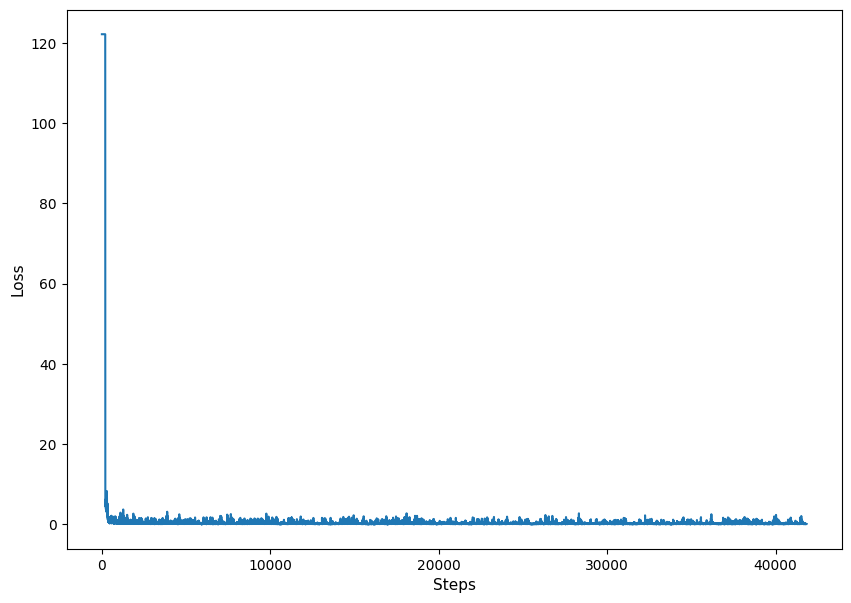

In [8]:
from collections import deque

epochs = 5000 #訓練5000次
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
replay = deque(maxlen=mem_size) #產生一個記憶串列（資料型別為deque）來儲存經驗回放的資料，並將其命名為replay
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #記錄移動的步數，初始化為0
  while(status == 1):
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) #利用小批次資料中的『目前狀態批次』來計算Q值3
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
    losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)